In [138]:
from sentence_transformers import SentenceTransformer
import torch
import lancedb
from openai import OpenAI
import re
import pandas as pd
import numpy as np
import json
import time

from google import genai
from google.genai import types
from dotenv import load_dotenv
from tqdm.notebook import tqdm
import os
load_dotenv('env_var')

True

In [139]:
from pathlib import Path
import sqlite3
from datetime import datetime
from uuid import uuid4
from copy import deepcopy

project_folder = Path('project_research')
project_folder.mkdir(parents=True, exist_ok=True)
research_json_folder = project_folder.joinpath('json_data')
research_json_folder.mkdir(parents=True, exist_ok=True)
database_location = project_folder.joinpath('research.sqlite')

conn = sqlite3.connect(database_location)
cursor = conn.cursor()

In [140]:
index = lancedb.connect('../wonky_data/indexes/')
table = index.open_table('sections_hybrid')
encoder = SentenceTransformer('nomic-ai/nomic-embed-text-v1.5', device='mps',trust_remote_code=True)

<All keys matched successfully>


In [141]:
table.create_fts_index(['text','source_file','id'], replace=True)

In [142]:
def format_documents(documents):
    formatted_texts = []
    report_ids = list(set([record['id'] for record in documents]))
    for id in report_ids:
        report_sections = [section for section in documents if section['id'] == id]
        report_sections = sorted(report_sections, key=lambda section: section['section_start'])
        report_text = [text['text'] for text in report_sections]
        report_text = [re.sub('\n+', '\n', _text) for _text in report_text]
        report_text = [re.sub(' +', ' ', _text) for _text in report_text]
        report_text = [re.sub(r'(\[.*?\])','', _text) for _text in report_text]
        report_text = [_text.replace('\\','') for _text in report_text]
        report_text = [re.sub(r'(\[.*?\])','', _text) for _text in report_text]
        report_text = [re.sub(r'(\n?-{10,})','', _text) for _text in report_text]
        report_text = [re.sub(r'(\n.*?#_Toc.*?\n)','', _text) for _text in report_text]
        report_text = [re.sub(r'(- \n)','', _text) for _text in report_text]
        report_text = [re.sub(r'\n{2,}','\n', _text) for _text in report_text]
        report_text = [_text.strip() for _text in report_text]
        report_text = '\n-----\n'.join(report_text)
        report_header = f"""**{report_sections[0]['id']}:** {report_sections[0]['title']}"""
        formatted_texts.append(f"""{report_header}\n{report_text}""".strip())
    # print(formatted_texts[0])
    return '\n=======\n'.join(formatted_texts)

client = OpenAI(base_url="http://localhost:1234/v1", api_key="lm-studio")
def call_llm(query, temperature=0.35, seed=42, model="gemma-3-12b-it-qat"):
    completion = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "user", "content": query}
        ],
        temperature=temperature,
        seed=seed,
    )
    return completion.choices[0].message.content

model = "gemini-2.0-flash"
total_tokens = list()

def call_llm_flash(query, temperature=0.1, seed=42, max_tokens=7500 ):
    client = genai.Client(api_key=os.environ['GEMINI_API_KEY'])
    retries = 3
    time_delay = 15
    for i in range(retries):
        try:
            response = client.models.generate_content(
                model=model,
                contents=[query],
                config=types.GenerateContentConfig(
                    max_output_tokens=max_tokens,
                    temperature=temperature,
                    seed=seed
                )
            )
            break
        except Exception as e:
            print(e)
            print(f"Retries left: {retries - i}")
            time.sleep(time_delay)
            continue



    total_tokens.append({'prompt_tokens':response.usage_metadata.prompt_token_count,
                         'completion_tokens':response.usage_metadata.candidates_token_count,
                         'total_tokens':response.usage_metadata.total_token_count,
                         'timestamp':datetime.now().strftime("%Y_%m_%d_%H_%M_%S")})

    return response.text

In [143]:
# This Python string contains the structured template for Foreign Policy Overviews
# from CRS reports. It is intended to be used as a detailed guide or prompt
# for a language model to extract information from a given report text.

FOREIGN_POLICY_OVERVIEW_TEMPLATE_STRING = """
## Foreign Policy Overview - Structured Document Template

**Objective:** To capture essential foreign policy information from a CRS report in a structured format, using a combination of verbatim quotes and concise, rule-based summaries, allowing for analysis of multiple geopolitical actors.

**General Rules for Information Extraction (Applicable to all fields unless overridden by specific field rules):**

1.  **Source Adherence:** All extracted information must originate directly from the provided CRS report. No external information, assumptions, or interpretations are to be introduced.
2.  **Attribution [id_ref__section_ref___subsection_ref]:** Whenever possible, provide general attribution by citing the page number(s) or specific section(s)/heading(s) of the report from which the information was extracted. This is especially critical for verbatim quotes and key analytical points. This general attribution is distinct from, and should be provided in addition to, any specific `[id_ref__section_ref___subsection_ref]` markers captured under Rule 7.
3.  **Verbatim Quotes:**
    * Rule 3.1: Use verbatim quotes when the report presents official statements, policy declarations, definitions of key terms, or when the precise wording is essential for conveying meaning or nuance.
    * Rule 3.2: Enclose all verbatim quotes in quotation marks (" ").
    * Rule 3.3: If a quote is lengthy and a concise summary can accurately capture its essence for a particular field, a summary may be used, but the option to include the full quote (perhaps in an appendix or a supplementary note field if we add one later) should be considered. The primary field should prioritize conciseness if a summary is adequate.
4.  **Paraphrased Summaries:**
    * Rule 4.1: Use paraphrased summaries for explaining complex concepts, synthesizing information from multiple parts of the report, or when the original text is too lengthy for the field's purpose.
    * Rule 4.2: Summaries must accurately reflect the source material's meaning, including any stated assumptions or conclusions presented in the report related to the summarized point.
    * Rule 4.3: Maintain neutral language. Avoid loaded terms or phrasing that introduces bias not present in the source.
    * Rule 4.4: Strive for conciseness while ensuring completeness of the relevant information for that field.
5.  **"Not Specified in Report":** If, after a thorough review, the information required for a field cannot be found in the report, enter "Not Specified in Report." Do not leave fields blank.
6.  **Consistency:** Apply heuristics and rules consistently across all reports analyzed.
7.  **Handling Specific `[id_ref__section_ref___subsection_ref]` Citation Pattern:**
    * Rule 7.1: While processing the source document text, be vigilant for citation markers matching the **exact alphanumeric pattern**: `[id_ref__section_ref___subsection_ref]`.
        * `id_ref` will be an alphanumeric identifier for the document.
        * `section_ref` will be an alphanumeric identifier for a section.
        * `subsection_ref` will be an alphanumeric identifier for a subsection.
        * Double underscores (`__`) separate `id_ref` from `section_ref`.
        * Triple underscores (`___`) separate `section_ref` from `subsection_ref`.
    * Rule 7.2: If such a `[id_ref__section_ref___subsection_ref]` pattern is identified *within the text segment being extracted* (either for a verbatim quote or as the basis for a summary) AND this pattern is used by the source document to refer to its own sections/subsections or those of closely related internal documents explicitly part of the same corpus:
        * Rule 7.2.1: If the extraction is a verbatim quote, this `[id_ref__section_ref___subsection_ref]` pattern, if present in the quoted material, must be included as part of the quote.
        * Rule 7.2.2: When such a `[id_ref__section_ref___subsection_ref]` marker is present in the text segment being extracted (whether quoted or summarized), this specific marker string (e.g., `[doc001__sec02___subA]`) MUST be preserved and included as part of the output for the relevant field. It should be presented alongside the general attribution from Rule 2.
            * *Example:* If the extracted content for a field is 'The initiative was deemed successful.' (attributed to 'p. 15, Evaluation Section' per Rule 2), and the original source text for this statement also contained the marker `[report42__eval01___successA]`, then the final entry for that field should be: '`[report42__eval01___successA]`'.
    * Rule 7.3: This rule (Rule 7) details how to handle the specific `[id_ref__section_ref___subsection_ref]` marker when found in the source text. The general page/section attribution from Rule 2 must still be provided for all extracted information.
    * Rule 7.4: Only the exact `[id_ref__section_ref___subsection_ref]` pattern is to be considered a valid citation marker for capture under this Rule 7. Other citation forms, such as numerical footnote markers (e.g., "\\[1\\]", "\\[23\\]"), author-date citations (e.g., "(Smith, 2020)"), or textual references like "see the section on X," are **not** to be captured or treated under this Rule 7. Such other citation forms may be part of a verbatim quote if they fall within the quoted text but should not be separately extracted or appended as if they were a `[id_ref__section_ref___subsection_ref]` marker.
8. **Citation Requirements:**
    * Every statement you write that is extracted from the text must be cited back to the general citation format that is in the document: `[id_ref__section_ref___subsection_ref]`.
    * Never provide a statement that does not have this citation because it is critical to validating the information in the report.

---

**1. Report Identification & Core Focus**

* **Field: Report Title**
    * **Heuristic: Verbatim Extraction**
        * Rule 1.1: Transcribe the full title of the CRS report exactly as it appears on the cover page or in the official citation.
* **Field: Report ID/Number**
    * **Heuristic: Verbatim Extraction**
        * Rule 1.1: Transcribe the unique identification number or code assigned to the CRS report (e.g., R4XXXX, IFXXXXX) exactly as it appears.
* **Field: Publication Date**
    * **Heuristic: Verbatim Extraction**
        * Rule 1.1: Transcribe the full publication date (e.g., Month Day, Year) exactly as it appears on the report.
* **Field: Primary Geographic Focus**
    * **Heuristic: Identification and Summarization**
        * Rule 1.1: Identify the primary country(ies), geographic region(s) (e.g., East Asia, Sub-Saharan Africa), or international/supranational bodies (e.g., United Nations, European Union) that are the principal subject of the foreign policy discussion in the report.
        * Rule 1.2: If the report explicitly states its geographic focus (e.g., in an introduction or summary), prioritize this statement.
        * Rule 1.3: If not explicitly stated, determine the focus by identifying the geographic entities most frequently discussed in relation to policy actions, implications, or analysis.
        * Rule 1.4: If multiple distinct geographic entities are central, list the top 2-3.
        * Rule 1.5: If the scope is global or covers a very broad, non-specific area, note this (e.g., "Global," "Multiple developing countries").
        * Rule 1.6: Present as a concise phrase or list.
* **Field: Primary Foreign Policy Issue(s) Addressed**
    * **Heuristic: Identification and Concise Statement**
        * Rule 1.1: Identify the central foreign policy problem(s), challenge(s), area(s) of engagement, or thematic concern(s) that the report analyzes.
        * Rule 1.2: Look for explicit statements of the issue in the report's summary, introduction, "Issues for Congress," or section headings.
        * Rule 1.3: Examples include: "US-China strategic competition," "Nuclear non-proliferation efforts concerning Iran," "Effectiveness of humanitarian aid in conflict zones," "International cybersecurity norms."
        * Rule 1.4: If multiple distinct issues are central, list them.
        * Rule 1.5: State each issue concisely, using terminology found in the report where possible.
* **Field: Definitions and Terms**
    * **Heuristic: Terms Defined**
        * Rule 1.1: Identify key terms that are explicitly defined in the source text.
        * Rule 1.2: Identify key terms that are reused throughout the text, but may not have an explicit definition. The definition must be inferred through usage.
        * Rule 1.3: List each key term in the following format: `**[key term]:** [definition] [doc001__sec02___subA]`
---

**2. Key Actors & Stakeholders**

* **Field: Major Geopolitical Actors Identified**
    * **Heuristic: Identification and Listing**
        * Rule 1.1: Identify all state actors (countries) and significant non-state actors whose foreign policies, objectives, actions, or stakes are a primary focus of the report's analysis regarding the identified foreign policy issue(s).
        * Rule 1.2: Non-state actors can include international organizations (e.g., UN, NATO, EU, ASEAN, African Union), regional blocs, and, if central to the policy discussion, major non-governmental organizations (NGOs), multinational corporations, or armed groups.
        * Rule 1.3: Determine "major" status based on:
            * The extent of discussion dedicated to the actor's policies, perspectives, or impact within the report.
            * The actor's direct involvement or significant influence on the foreign policy issue(s).
            * The actor being a direct subject of policy actions or considerations discussed.
        * Rule 1.4: List the identified actors by their formal names as used in the report.
        * Rule 1.5: This list will directly inform the creation of subsections under "4. Detailed Analysis of Major Geopolitical Actors." Each actor listed here must have a corresponding subsection in Section 4.

---

**3. Policy Background & Context**

* **Field: Historical Context Summary**
    * **Heuristic: Summarization of Relevant Background**
        * Rule 1.1: Identify sections or statements in the report that provide historical background or context leading up to the current foreign policy issue(s).
        * Rule 1.2: Extract information detailing key past events, preceding policies, or evolving relationships that the report deems significant for understanding the present situation.
        * Rule 1.3: Focus on information that directly shapes or explains the genesis and nature of the current policy challenges or dynamics.
        * Rule 1.4: Summarize this information concisely. Avoid excessive detail on historical aspects not directly relevant to the core issues being analyzed in the report.
* **Field: Current Status/Situation Overview**
    * **Heuristic: Summarization of the Prevailing Conditions**
        * Rule 1.1: Identify the report's description of the state of affairs concerning the primary foreign policy issue(s) at the time of the report's writing.
        * Rule 1.2: This includes current political dynamics, security situations, economic conditions, diplomatic engagements, or humanitarian circumstances relevant to the issue.
        * Rule 1.3: Extract information that provides a "snapshot" of the prevailing environment in which policies are being made and implemented.
        * Rule 1.4: Summarize concisely, focusing on the most salient aspects of the current situation as presented by the report.
* **Field: Key Treaties, Agreements, or Legal Frameworks Mentioned**
    * **Heuristic: Identification and Description of Relevance**
        * Rule 1.1: Identify all international treaties, bilateral/multilateral agreements, UN resolutions, customary international law, or domestic legal frameworks (of any relevant actor) that the report cites as being central to, or significantly impacting, the foreign policy issue(s).
        * Rule 1.2: List the formal names of these legal instruments.
        * Rule 1.3: For each instrument listed, provide a brief paraphrased description of its relevance or impact on the policy issue, as explained in the report. (e.g., "Treaty X: Establishes limitations on Y, which the report notes is a point of contention.").

---

**4. Detailed Analysis of Major Geopolitical Actors**

*Instruction:* For each Major Geopolitical Actor identified in Section 2, create a subsection with the following fields. Apply the General Rules for Information Extraction.

* **Subsection: \[Actor Name\]** (e.g., "People's Republic of China," "European Union," "Russian Federation")

    * **Field: Stated Objectives, Position, or Interests of \[Actor Name\]**
        * **Heuristic 1: Direct Statements**
            * Rule 1.1.1: Identify any direct quotations or explicit statements within the report attributed to \[Actor Name\] or its officials that articulate its objectives, official positions, or core interests regarding the foreign policy issue.
            * Rule 1.1.2: If available, prioritize using these verbatim statements.
        * **Heuristic 2: Report's Analysis of Objectives/Interests**
            * Rule 1.2.1: If direct statements are not available or are insufficient, identify the report's own analysis or summary of \[Actor Name\]'s aims, goals, motivations, strategic calculations, or key concerns related to the policy issue.
            * Rule 1.2.2: Paraphrase this analysis, ensuring to capture the nuance of what the report claims are the actor's objectives/interests.
            * Rule 1.2.3: Note if the report indicates these are *perceived* or *inferred* interests versus officially declared ones.
    * **Field: Current Policy/Strategy Description for \[Actor Name\]**
        * **Heuristic: Synthesis of Reported Policy Approach**
            * Rule 1.1: Identify the report's description of \[Actor Name\]'s current overarching policy, strategy, or general approach concerning the foreign policy issue(s).
            * Rule 1.2: This may involve synthesizing information from various sections of the report.
            * Rule 1.3: Detail the main components, pillars, or guiding principles of this policy/strategy as presented.
            * Rule 1.4: Support with verbatim quotes of specific policy tenets or official strategy documents if cited and concise.
    * **Field: Policy Instruments Used/Considered by \[Actor Name\]**
        * **Heuristic: Identification and Categorization of Tools**
            * Rule 1.1: Identify specific actions, tools, or methods the report states \[Actor Name\] is currently employing or actively considering to implement its policy or achieve its objectives related to the issue.
            * Rule 1.2: Examples include: diplomatic initiatives (negotiations, public statements), economic measures (trade agreements, investment, tariffs, financial leverage), sanctions (unilateral/multilateral), foreign aid (developmental, humanitarian, security), military actions/postures (deployments, exercises, arms sales), intelligence activities, information/cyber operations, legal actions (international courts, domestic law with extraterritorial effect), support for proxies, etc.
            * Rule 1.3: List each distinct instrument.
            * Rule 1.4: For each instrument, briefly describe its specific application, purpose, or target in the context of the issue, as detailed in the report.
    * **Field: Funding/Resource Allocation by \[Actor Name\] (If Detailed)**
        * **Heuristic: Extraction of Specific Financial/Resource Data**
            * Rule 1.1: Identify any specific figures, budgetary details, or significant resource commitments (financial, personnel, material) that the report attributes to \[Actor Name\] in relation to its policy on the issue.
            * Rule 1.2: Extract verbatim figures where possible.
            * Rule 1.3: Note the purpose, source (if mentioned, e.g., specific government agency), and timeframe of the funding/resource allocation if the report provides this level of detail.
            * Rule 1.4: If precise figures are not given, but the report describes significant resource implications (e.g., "substantial investment," "major reallocation of military assets"), summarize this qualitatively.
    * **Field: Reported Successes/Effectiveness of \[Actor Name\]'s Policy (If Any)**
        * **Heuristic: Identification of Positive Outcomes/Assessments**
            * Rule 1.1: Identify any statements, analysis, or evidence presented in the report that suggests \[Actor Name\]'s policy or specific actions have been successful, effective, or are achieving their intended outcomes in relation to the foreign policy issue.
            * Rule 1.2: This could include achieving stated goals, positive impacts on the situation, or favorable responses from other actors, as assessed *by the report*.
            * Rule 1.3: Paraphrase these reported successes, clearly indicating that this is the report's assessment or reporting of an assessment.
    * **Field: Reported Challenges, Criticisms, or Limitations of \[Actor Name\]'s Policy**
        * **Heuristic: Identification of Negative Outcomes/Obstacles/Critiques**
            * Rule 1.1: Identify any statements, analysis, or evidence presented in the report that describe challenges, obstacles, failures, unintended negative consequences, criticisms (from internal or external sources cited in the report), or limitations associated with \[Actor Name\]'s policy or specific actions.
            * Rule 1.2: This could include implementation difficulties, lack of desired impact, negative reactions from other actors, resource constraints, or internal contradictions in the policy, as assessed *by the report*.
            * Rule 1.3: Paraphrase these reported issues, clearly indicating that this is the report's assessment or reporting of an assessment/criticism.
    * **Field: Internal Governmental/Legislative Considerations or Actions within \[Actor Name\] (If Detailed)**
        * **Heuristic: Extraction of Domestic Policy-Making Context**
            * Rule 1.1: Identify information in the report detailing relevant internal processes, debates, decisions, or actions within \[Actor Name\]'s own governmental, parliamentary/legislative, judicial, or key decision-making structures that influence or relate to its foreign policy on the issue.
            * Rule 1.2: Examples: specific legislation passed or debated, significant policy reviews, executive directives, important public statements by key leaders shaping domestic consensus or policy direction, judicial rulings with foreign policy implications.
            * Rule 1.3: Summarize these internal factors and their relevance to the actor's foreign policy as described by the report.

---

**5. Broader Policy Environment & CRS Analysis**

* **Field: Interactions & Interdependencies Between Actor Policies (If Analyzed)**
    * **Heuristic: Analysis of Inter-Actor Dynamics**
        * Rule 1.1: Identify sections where the report analyzes how the policies, strategies, or actions of the different Major Geopolitical Actors (identified in Section 2) interact with, influence, or depend on each other.
        * Rule 1.2: Look for descriptions of cooperation, competition, conflict, synergy, mutual reinforcement, or contradiction between actor policies.
        * Rule 1.3: Summarize the report's analysis of these interdependencies and their implications for the overall foreign policy issue.
* **Field: Overall Challenges or Systemic Issues Identified by CRS**
    * **Heuristic: Identification of Overarching Problems**
        * Rule 1.1: Identify broader challenges, problems, or systemic factors related to the foreign policy issue that the report discusses as transcending any single actor's policy or being inherent to the nature of the issue itself.
        * Rule 1.2: Examples: regional instability, resource scarcity, climate change impacts, technological disruption (e.g., AI, cyber threats), global health crises, erosion of international norms, difficulties in multilateral coordination.
        * Rule 1.3: List and briefly describe these systemic issues as characterized by the report.
* **Field: Policy Options or Alternatives Discussed by CRS (for addressing the overarching issue or for consideration by policymakers generally)**
    * **Heuristic: Extraction of CRS-Proposed/Analyzed Options**
        * Rule 1.1: Identify any distinct policy options, alternative courses of action, or recommendations that the CRS report itself proposes, analyzes, or presents for consideration by policymakers (often, but not exclusively, the U.S. Congress).
        * Rule 1.2: These options might be aimed at addressing the overarching foreign policy issue, specific aspects of it, or challenges in the interactions between actors.
        * Rule 1.3: For each distinct option identified:
            * Rule 1.3.1: Summarize the option clearly.
            * Rule 1.3.2: Detail the report's stated rationale, potential benefits, potential drawbacks, feasibility considerations, or implications associated with that option.
* **Field: Potential Future Outlook/Scenarios (for the overarching issue, considering actor interactions)**
    * **Heuristic: Summarization of Projections and Contingencies**
        * Rule 1.1: Identify any sections where the report discusses potential future developments, trends, trajectories, or alternative scenarios concerning the foreign policy issue.
        * Rule 1.2: This includes the report's assessment of how the situation might evolve based on current trends, actor behaviors, and potential trigger events.
        * Rule 1.3: For each significant outlook or scenario presented:
            * Rule 1.3.1: Describe the scenario.
            * Rule 1.3.2: Identify the key conditions, factors, or assumptions the report states could lead to or influence this future state.

---

**6. U.S. Congressional Role & Considerations**

* **Field: Key U.S. Congressional Actions Taken (e.g., Legislation, Hearings, Oversight)**
    * **Heuristic: Identification of Specific Legislative/Oversight Activities**
        * Rule 1.1: Identify any specific actions taken by the U.S. Congress (or its committees/members) related to the foreign policy issue that are mentioned in the report.
        * Rule 1.2: This includes enacted legislation, proposed bills, resolutions, congressional hearings (with dates or topics if provided), formal oversight activities, letters to executive agencies, or significant statements by congressional leadership.
        * Rule 1.3: List these actions. Include bill numbers (e.g., H.R. XXXX, S. XXXX), Public Law numbers, or hearing titles/dates if specified in the report.
* **Field: Issues for U.S. Congress/Oversight Considerations Highlighted by CRS**
    * **Heuristic: Extraction of Explicit or Implicit Guidance for Congress**
        * Rule 1.1: Identify sections, often titled "Issues for Congress," "Policy Considerations," or similar, where the report explicitly outlines questions, decision points, areas for scrutiny, or potential legislative/oversight roles for the U.S. Congress.
        * Rule 1.2: If not in a dedicated section, identify analytical points throughout the report that implicitly raise considerations for congressional action or oversight (e.g., discussion of funding gaps, legal ambiguities, policy effectiveness needing review).
        * Rule 1.3: Extract these points, using verbatim quotes for direct "Issues for Congress" statements where concise and appropriate, otherwise paraphrase.
        * Rule 1.4: Focus on actionable or strategic considerations presented for Congress.

---

**7. Report's Key Assumptions & Conclusions (Overall)**

* **Field: Overarching Assumptions Made by the Report (If Explicitly Stated or Clearly Identifiable)**
    * **Heuristic: Identification of Foundational Premises**
        * Rule 1.1: Scrutinize the report's introduction, analytical sections, and conclusion for explicit statements of assumptions that underpin its overall analysis.
        * Rule 1.2: If not explicit, identify fundamental premises that appear to be taken for granted by the report's authors and upon which their main arguments or interpretations rest. These might relate to:
            * The motivations or likely behavior of key actors.
            * The stability or predictability of certain geopolitical or economic conditions.
            * The efficacy or limitations of particular policy instruments.
            * The interpretation of international law or norms.
        * Rule 1.3: List these assumptions. If inferring an assumption, clearly state that it is an inferred underpinning of the report's analysis.
* **Field: Report's Main Conclusion(s) or Key Judgments**
    * **Heuristic: Synthesis of Primary Takeaways**
        * Rule 1.1: Identify the most critical, overarching conclusions, findings, or judgments offered by the CRS report as a whole regarding the foreign policy issue discussed.
        * Rule 1.2: Look for these in the report's concluding section, executive summary, or as prominently emphasized analytical points.
        * Rule 1.3: Synthesize these into a concise summary.
        * Rule 1.4: If the report offers several distinct main conclusions, list them.
        * Rule 1.5: Verbatim quotes of particularly salient concluding statements can be used if they are concise and directly capture a key judgment.
"""

# Example of how you might use this template string in your Python code:
if __name__ == "__main__":
    # You can print the template to verify its content:
    # print(FOREIGN_POLICY_OVERVIEW_TEMPLATE_STRING)

    # In a real application, your workflow might look like this:
    # 1. Obtain the text of a CRS report.
    #    Example:
    #    crs_report_actual_text = "" # Load your specific CRS report text here
    #    with open("path_to_your_crs_report.txt", "r", encoding="utf-8") as f:
    #        crs_report_actual_text = f.read()

    # 2. Construct a prompt for a Large Language Model (LLM).
    #    This prompt would include the CRS report text and the
    #    FOREIGN_POLICY_OVERVIEW_TEMPLATE_STRING as instructions.
    #    Example prompt structure:
    #    prompt_to_llm = f"""
    #    You are an expert policy analyst tasked with extracting structured information from Congressional Research Service (CRS) reports.
    #    Carefully review the provided CRS Report Text below.
    #    Then, fill out the fields in the following Structured Document Template using information exclusively from the report.
    #    Adhere strictly to all General Rules, Heuristics, and specific Field Rules outlined in the template.
    #    Pay close attention to the citation and attribution rules, especially Rule 2 for general attribution and Rule 7 for the specific '[id_ref__section_ref___subsection_ref]' citation pattern.
    #    If information for a field is not found in the report, state 'Not Specified in Report'.

    #    CRS Report Text:
    #    --------------------------------------------------
    #    {crs_report_actual_text}
    #    --------------------------------------------------

    #    Structured Document Template:
    #    --------------------------------------------------
    #    {FOREIGN_POLICY_OVERVIEW_TEMPLATE_STRING}
    #    --------------------------------------------------

    #    Please provide the filled structured document based on the report text and the template rules.
    #    Begin your output with "## Foreign Policy Overview - Structured Document" and follow the template structure.
    #    """

    # 3. Send this prompt to your chosen LLM.
    #    (This step would involve using an API for an LLM service)
    #    Example (conceptual):
    #    # response_from_llm = your_llm_api_call(prompt_to_llm)

    # 4. Process the LLM's response, which should be the filled-out structured document.
    #    # print(response_from_llm)
    pass


In [144]:
prompt_to_llm_foreign = """
#    Carefully review the provided CRS Report Text below.
#    Then, fill out the fields in the following Structured Document Template using information exclusively from the report.
#    Adhere strictly to all General Rules, Heuristics, and specific Field Rules outlined in the template.
#    Pay close attention to the citation and attribution rules, especially Rule 7 for internal cross-references.
#    If information for a field is not found in the report, state 'Not Specified in Report'.

#    CRS Report Text:
#    --------------------------------------------------
#    {report_sections}
#    --------------------------------------------------

#    Structured Document Template:
#    --------------------------------------------------
#    {OVERVIEW_TEMPLATE_STRING}
#    --------------------------------------------------

#    Please provide the filled structured document based on the report text and the template rules.
#    Separate the sections by a markdown line break: '---'
#    Begin your output with "## Foreign Policy Overview - Structured Document" and follow the template structure.
#    """

In [145]:
# This Python string contains the structured template for Domestic Policy Overviews
# from CRS reports (or similar analytical documents). It is intended to be used
# as a detailed guide or prompt for a language model to extract information
# from a given report text.

DOMESTIC_POLICY_OVERVIEW_TEMPLATE_STRING = """
## Domestic Policy Overview - Structured Document Template

**Objective:** To capture essential domestic policy information from an analytical report in a structured format, using a combination of verbatim quotes and concise, rule-based summaries, allowing for analysis of policies within any given domestic jurisdiction.

**General Rules for Information Extraction (Applicable to all fields unless overridden by specific field rules):**

1.  **Source Adherence:** All extracted information must originate directly from the provided report. No external information, assumptions, or interpretations are to be introduced.
2.  **Attribution [id_ref__section_ref___subsection_ref]:** Whenever possible, provide general attribution by citing the page number(s) or specific section(s)/heading(s) of the report from which the information was extracted. This is especially critical for verbatim quotes and key analytical points. This general attribution is distinct from, and should be provided in addition to, any specific `[id_ref__section_ref___subsection_ref]` markers captured under Rule 7.
3.  **Verbatim Quotes:**
    * Rule 3.1: Use verbatim quotes when the report presents official statements, policy declarations, definitions of key terms, or when the precise wording is essential for conveying meaning or nuance.
    * Rule 3.2: Enclose all verbatim quotes in quotation marks (" ").
    * Rule 3.3: If a quote is lengthy and a concise summary can accurately capture its essence for a particular field, a summary may be used, but the option to include the full quote (perhaps in an appendix or a supplementary note field if we add one later) should be considered. The primary field should prioritize conciseness if a summary is adequate.
4.  **Paraphrased Summaries:**
    * Rule 4.1: Use paraphrased summaries for explaining complex concepts, synthesizing information from multiple parts of the report, or when the original text is too lengthy for the field's purpose.
    * Rule 4.2: Summaries must accurately reflect the source material's meaning, including any stated assumptions or conclusions presented in the report related to the summarized point.
    * Rule 4.3: Maintain neutral language. Avoid loaded terms or phrasing that introduces bias not present in the source.
    * Rule 4.4: Strive for conciseness while ensuring completeness of the relevant information for that field.
5.  **"Not Specified in Report":** If, after a thorough review, the information required for a field cannot be found in the report, enter "Not Specified in Report." Do not leave fields blank.
6.  **Consistency:** Apply heuristics and rules consistently across all reports analyzed.
7.  **Handling Specific `[id_ref__section_ref___subsection_ref]` Citation Pattern:**
    * Rule 7.1: While processing the source document text, be vigilant for citation markers matching the **exact alphanumeric pattern**: `[id_ref__section_ref___subsection_ref]`.
        * `id_ref` will be an alphanumeric identifier for the document.
        * `section_ref` will be an alphanumeric identifier for a section.
        * `subsection_ref` will be an alphanumeric identifier for a subsection.
        * Double underscores (`__`) separate `id_ref` from `section_ref`.
        * Triple underscores (`___`) separate `section_ref` from `subsection_ref`.
    * Rule 7.2: If such a `[id_ref__section_ref___subsection_ref]` pattern is identified *within the text segment being extracted* (either for a verbatim quote or as the basis for a summary) AND this pattern is used by the source document to refer to its own sections/subsections or those of closely related internal documents explicitly part of the same corpus:
        * Rule 7.2.1: If the extraction is a verbatim quote, this `[id_ref__section_ref___subsection_ref]` pattern, if present in the quoted material, must be included as part of the quote.
        * Rule 7.2.2: When such a `[id_ref__section_ref___subsection_ref]` marker is present in the text segment being extracted (whether quoted or summarized), this specific marker string (e.g., `[doc001__sec02___subA]`) MUST be preserved and included as part of the output for the relevant field.
            * *Example:* If the extracted content for a field is 'The program funding was increased by 10%.' (attributed to 'p. 15, Budget Allocation Section' per Rule 2), and the original source text for this statement also contained the marker `[report42__budget01___increaseA]`, then the final entry for that field should be: 'The program funding was increased by 10%. `[report42__budget01___increaseA]`'.
    * Rule 7.3: This rule (Rule 7) details how to handle the specific `[id_ref__section_ref___subsection_ref]` marker when found in the source text. The general page/section attribution from Rule 2 (e.g. page number or general section heading) should ideally still be noted by the analyst for traceability, even if the final output format for the field emphasizes the `[id_ref__section_ref___subsection_ref]` marker as shown in the Rule 7.2.2 example.
    * Rule 7.4: Only the exact `[id_ref__section_ref___subsection_ref]` pattern is to be considered a valid citation marker for capture under this Rule 7. Other citation forms, such as numerical footnote markers (e.g., "\\[1\\]", "\\[23\\]"), author-date citations (e.g., "(Smith, 2020)"), or textual references like "see the section on X," are **not** to be captured or treated under this Rule 7. Such other citation forms may be part of a verbatim quote if they fall within the quoted text but should not be separately extracted or appended as if they were a `[id_ref__section_ref___subsection_ref]` marker.
8. **Citation Requirements:**
    * Every statement you write that is extracted from the text must be cited back to the general citation format that is in the document: `[id_ref__section_ref___subsection_ref]`.
    * Never provide a statement that does not have this citation because it is critical to validating the information in the report. If a specific `[id_ref__section_ref___subsection_ref]` marker is not present for a piece of information, use the general page/section attribution from Rule 2. The ideal is to have the specific marker; if absent, general attribution is the minimum.

---

**1. Report Identification & Core Focus**

* **Field: Report Title**
    * **Heuristic: Verbatim Extraction**
        * Rule 1.1: Transcribe the full title of the report exactly as it appears on the cover page or in the official citation.
* **Field: Report ID/Number**
    * **Heuristic: Verbatim Extraction**
        * Rule 1.1: Transcribe the unique identification number or code assigned to the report (e.g., R4XXXX, IFXXXXX, GovDocXYZ) exactly as it appears.
* **Field: Publication Date**
    * **Heuristic: Verbatim Extraction**
        * Rule 1.1: Transcribe the full publication date (e.g., Month Day, Year) exactly as it appears on the report.
* **Field: Primary Domestic Jurisdiction/Entity Focus**
    * **Heuristic: Identification and Summarization**
        * Rule 1.1: Identify the primary domestic jurisdiction (e.g., country, state, province, municipality) or specific governmental entity (e.g., Ministry of Health, Department of Education) that is the principal subject of the domestic policy discussion in the report.
        * Rule 1.2: If the report explicitly states its jurisdictional/entity focus, prioritize this statement.
        * Rule 1.3: If not explicitly stated, determine the focus by identifying the jurisdiction or entity most frequently discussed in relation to policy actions, implications, or analysis.
        * Rule 1.4: Present as a concise phrase.
* **Field: Primary Domestic Policy Issue(s) Addressed**
    * **Heuristic: Identification and Concise Statement**
        * Rule 1.1: Identify the central domestic policy problem(s), challenge(s), area(s) of public concern, or thematic focus (e.g., healthcare access, educational standards, unemployment, housing shortages, environmental protection, criminal justice reform) that the report analyzes.
        * Rule 1.2: Look for explicit statements of the issue in the report's summary, introduction, or section headings.
        * Rule 1.3: If multiple distinct issues are central, list them.
        * Rule 1.4: State each issue concisely, using terminology found in the report where possible. Each issue must be accompanied by a `[id_ref__section_ref___subsection_ref]` citation.
* **Field: Definitions and Terms**
    * **Heuristic: Terms Defined**
        * Rule 1.1: Identify key terms that are explicitly defined in the source text.
        * Rule 1.2: Identify key terms that are reused throughout the text, but may not have an explicit definition. The definition must be inferred through usage.
        * Rule 1.3: List each key term in the following format: `**[key term]:** [definition] [doc001__sec02___subA]` (ensure the `[id_ref__section_ref___subsection_ref]` citation is present for each definition).
---

**2. Key Domestic Actors, Entities, & Affected Groups Identified**

* **Field: Key Domestic Actors, Entities, & Affected Groups Identified**
    * **Heuristic: Identification and Listing**
        * Rule 1.1: Identify all significant domestic actors, governmental entities, non-governmental organizations, private sector players, or specific demographic/social groups whose roles, policies, objectives, actions, or stakes are a primary focus of the report's analysis regarding the identified domestic policy issue(s).
        * Rule 1.2: Examples: Government ministries/departments (e.g., Ministry of Finance, Environmental Protection Agency), legislative bodies/committees, judicial branches, regional/local governments, political parties, regulatory agencies, public corporations, trade unions, business associations, advocacy groups, civil society organizations, academic institutions, specific communities or demographic groups (e.g., low-income households, elderly population, specific ethnic groups).
        * Rule 1.3: Determine "key" status based on:
            * The extent of discussion dedicated to the actor/entity/group's involvement, perspective, or impact within the report.
            * The actor/entity/group's direct role in policy formulation, implementation, or being significantly affected by the policy.
        * Rule 1.4: List the identified actors/entities/groups by their formal names or clear descriptors as used in the report. Each actor/entity/group listed must be accompanied by a citation `[id_ref__section_ref___subsection_ref]` indicating where they are identified or predominantly discussed.
        * Rule 1.5: This list will directly inform the creation of subsections under "4. Detailed Analysis of Key Domestic Actors, Entities, & Affected Groups." Each item listed here must have a corresponding subsection in Section 4.

---

**3. Policy Background & Context**

* **Field: Historical Context Summary**
    * **Heuristic: Summarization of Relevant Background**
        * Rule 1.1: Identify sections or statements in the report that provide historical background or context leading up to the current domestic policy issue(s).
        * Rule 1.2: Extract information detailing key past events, preceding policies, societal trends, or evolving conditions that the report deems significant for understanding the present situation. Each piece of information must have a `[id_ref__section_ref___subsection_ref]` citation.
        * Rule 1.3: Focus on information that directly shapes or explains the genesis and nature of the current policy challenges or dynamics.
        * Rule 1.4: Summarize this information concisely. Avoid excessive detail on historical aspects not directly relevant to the core issues being analyzed in the report.
* **Field: Current Status/Situation Overview**
    * **Heuristic: Summarization of the Prevailing Conditions**
        * Rule 1.1: Identify the report's description of the state of affairs concerning the primary domestic policy issue(s) at the time of the report's writing. Each statement must have a `[id_ref__section_ref___subsection_ref]` citation.
        * Rule 1.2: This includes current social conditions, economic indicators, political debates, public opinion trends, or implementation status of relevant programs relevant to the issue.
        * Rule 1.3: Extract information that provides a "snapshot" of the prevailing environment in which policies are being made and implemented.
        * Rule 1.4: Summarize concisely, focusing on the most salient aspects of the current situation as presented by the report.
* **Field: Key Legislation, Regulations, Constitutional Provisions, or Legal Frameworks Mentioned**
    * **Heuristic: Identification and Description of Relevance**
        * Rule 1.1: Identify all key domestic laws, statutes, regulations, constitutional articles/amendments, significant judicial precedents, or other legal frameworks that the report cites as being central to, or significantly impacting, the domestic policy issue(s).
        * Rule 1.2: List the formal names or common identifiers of these legal instruments (e.g., "Healthcare Act of 2023," "Title IX of the Education Amendments," "National Environmental Policy Framework"). Each instrument must be followed by a `[id_ref__section_ref___subsection_ref]` citation.
        * Rule 1.3: For each instrument listed, provide a brief paraphrased description of its relevance or impact on the policy issue, as explained in the report. This description must also be followed by a `[id_ref__section_ref___subsection_ref]` citation. (e.g., "Clean Air Act Amendment of 2020: Mandates new emissions standards for X industry. `[doc001__sec03___legalContextA]`").

---

**4. Detailed Analysis of Key Domestic Actors, Entities, & Affected Groups**

*Instruction:* For each Key Domestic Actor, Entity, or Affected Group identified in Section 2, create a subsection with the following fields. Apply the General Rules for Information Extraction. Every piece of extracted information in the following fields MUST be accompanied by a `[id_ref__section_ref___subsection_ref]` citation.

* **Subsection: \[Actor/Entity/Group Name\]** (e.g., "Ministry of Education," "National Farmers Union," "Urban Low-Income Residents")

    * **Field: Stated Objectives, Position, Interests, or Reported Experiences of \[Actor/Entity/Group Name\]**
        * **Heuristic 1: Direct Statements/Reported Positions**
            * Rule 1.1.1: Identify any direct quotations or explicit statements within the report attributed to \[Actor/Entity/Group Name\] or its representatives that articulate its objectives, official positions, core interests, or reported experiences regarding the domestic policy issue.
            * Rule 1.1.2: If available, prioritize using these verbatim statements. Each quote must end with its `[id_ref__section_ref___subsection_ref]` citation.
        * **Heuristic 2: Report's Analysis of Objectives/Interests/Experiences**
            * Rule 1.2.1: If direct statements are not available/sufficient, identify the report's own analysis or summary of \[Actor/Entity/Group Name\]'s aims, goals, motivations, concerns, or reported experiences/impacts related to the policy issue.
            * Rule 1.2.2: Paraphrase this analysis, ensuring to capture the nuance. Each paraphrased statement must end with its `[id_ref__section_ref___subsection_ref]` citation.
            * Rule 1.2.3: Note if the report indicates these are *perceived* or *inferred* interests/experiences versus officially declared/documented ones. This note also requires a citation.
    * **Field: Current Policy/Stance/Program Description or Role of \[Actor/Entity/Group Name\]**
        * **Heuristic: Synthesis of Reported Approach/Role**
            * Rule 1.1: Identify the report's description of \[Actor/Entity/Group Name\]'s current policy (if a policy-making body), stance, implemented programs, advocacy efforts, or general role concerning the domestic policy issue(s).
            * Rule 1.2: This may involve synthesizing information from various sections of the report.
            * Rule 1.3: Detail the main components or guiding principles of this policy/stance/program/role as presented. Each component must have a `[id_ref__section_ref___subsection_ref]` citation.
            * Rule 1.4: Support with verbatim quotes if concise and illustrative. Each quote must have its citation.
    * **Field: Policy Levers, Programs, or Actions Implemented/Advocated by/Affecting \[Actor/Entity/Group Name\]**
        * **Heuristic: Identification and Categorization of Mechanisms**
            * Rule 1.1: Identify specific policy levers (e.g., taxation, subsidies, regulation), programs, services, advocacy actions, or other mechanisms the report states \[Actor/Entity/Group Name\] is employing, advocating for, or is primarily affected by, in relation to the issue.
            * Rule 1.2: Examples: legislative proposals, regulatory changes, budget allocations, public awareness campaigns, service delivery models, legal challenges, community organizing, research dissemination.
            * Rule 1.3: List each distinct mechanism/action. Each must have a `[id_ref__section_ref___subsection_ref]` citation.
            * Rule 1.4: For each, briefly describe its specific application, purpose, or impact in the context of the issue, as detailed in the report. This description must also have a citation.
    * **Field: Funding/Resource Allocation by/for \[Actor/Entity/Group Name\] (If Detailed)**
        * **Heuristic: Extraction of Specific Financial/Resource Data**
            * Rule 1.1: Identify any specific figures, budgetary details, or significant resource commitments (financial, personnel, material) that the report attributes to or for \[Actor/Entity/Group Name\] in relation to its role or programs on the issue. Each piece of data must have a `[id_ref__section_ref___subsection_ref]` citation.
            * Rule 1.2: Extract verbatim figures where possible.
            * Rule 1.3: Note the purpose, source (if mentioned), and timeframe of the funding/resource allocation if the report provides this level of detail. Each note requires a citation.
            * Rule 1.4: If precise figures are not given, but the report describes significant resource implications, summarize this qualitatively. This summary requires a citation.
    * **Field: Reported Outcomes/Impacts/Effectiveness related to \[Actor/Entity/Group Name\]'s Role or Policy (If Any)**
        * **Heuristic: Identification of Positive or Notable Outcomes/Assessments**
            * Rule 1.1: Identify any statements, analysis, or evidence presented in the report that suggests \[Actor/Entity/Group Name\]'s policy, actions, or involvement has led to specific outcomes, impacts (positive or negative, intended or unintended), or has been effective in some measure. Each statement must have a `[id_ref__section_ref___subsection_ref]` citation.
            * Rule 1.2: This could include achieving stated goals, measurable changes in conditions, or feedback from affected populations, as assessed *by the report*.
            * Rule 1.3: Paraphrase these reported outcomes/impacts, clearly indicating this is the report's assessment. Each paraphrase requires a citation.
    * **Field: Reported Challenges, Criticisms, Unintended Consequences, or Limitations related to \[Actor/Entity/Group Name\]'s Role or Policy**
        * **Heuristic: Identification of Negative Outcomes/Obstacles/Critiques**
            * Rule 1.1: Identify statements, analysis, or evidence in the report describing challenges, obstacles, failures, unintended negative consequences, criticisms, or limitations associated with \[Actor/Entity/Group Name\]'s policy, actions, or the way the policy affects them. Each statement must have a `[id_ref__section_ref___subsection_ref]` citation.
            * Rule 1.2: This could include implementation difficulties, lack of desired impact, negative reactions, resource constraints, or equity concerns, as assessed *by the report*.
            * Rule 1.3: Paraphrase these reported issues, clearly indicating this is the report's assessment. Each paraphrase requires a citation.
    * **Field: Internal Dynamics, Strategies, or Considerations within \[Actor/Entity/Group Name\] (If Detailed)**
        * **Heuristic: Extraction of Internal Context**
            * Rule 1.1: Identify information in the report detailing relevant internal processes, strategies, debates, decision-making structures, or internal considerations within \[Actor/Entity/Group Name\] that influence its approach or response to the domestic policy issue. Each piece of information requires a `[id_ref__section_ref___subsection_ref]` citation.
            * Rule 1.2: Examples: For a government agency - internal reviews, bureaucratic politics. For an advocacy group - campaign strategies, member deliberations. For a community - reported internal consensus or division.
            * Rule 1.3: Summarize these internal factors and their relevance as described by the report. Each summary requires a citation.

---

**5. Broader Policy Environment & Report Analysis**

*Instruction:* Every piece of extracted information in the following fields MUST be accompanied by a `[id_ref__section_ref___subsection_ref]` citation.

* **Field: Interactions & Interdependencies Between Domestic Actors/Entities/Policies (If Analyzed)**
    * **Heuristic: Analysis of Inter-Actor/Entity Dynamics**
        * Rule 1.1: Identify sections where the report analyzes how the policies, strategies, actions, or positions of the different Key Domestic Actors/Entities/Groups (identified in Section 2) interact with, influence, or depend on each other.
        * Rule 1.2: Look for descriptions of cooperation, conflict, competition, partnership, or influence dynamics.
        * Rule 1.3: Summarize the report's analysis of these interdependencies and their implications for the overall domestic policy issue. Each summary must have a `[id_ref__section_ref___subsection_ref]` citation.
* **Field: Overall Challenges or Systemic Issues Identified by Report**
    * **Heuristic: Identification of Overarching Problems**
        * Rule 1.1: Identify broader challenges, problems, or systemic factors related to the domestic policy issue that the report discusses as transcending any single actor/entity's policy or being inherent to the nature of the issue itself.
        * Rule 1.2: Examples: socio-economic inequalities, demographic shifts, technological disruption, public finance constraints, governance capacity, inter-governmental relations.
        * Rule 1.3: List and briefly describe these systemic issues as characterized by the report. Each issue and its description must have a `[id_ref__section_ref___subsection_ref]` citation.
* **Field: Policy Options or Alternatives Discussed by Report (for addressing the overarching issue or for consideration by policymakers generally)**
    * **Heuristic: Extraction of Report-Proposed/Analyzed Options**
        * Rule 1.1: Identify any distinct policy options, alternative courses of action, or recommendations that the report itself proposes, analyzes, or presents for consideration by policymakers or stakeholders.
        * Rule 1.2: These options might be aimed at addressing the overarching domestic policy issue, specific aspects of it, or challenges in the interactions between actors/entities.
        * Rule 1.3: For each distinct option identified:
            * Rule 1.3.1: Summarize the option clearly. The summary must have a `[id_ref__section_ref___subsection_ref]` citation.
            * Rule 1.3.2: Detail the report's stated rationale, potential benefits, potential drawbacks, feasibility considerations, or implications associated with that option. Each detail must have a citation.
* **Field: Potential Future Outlook/Scenarios (for the overarching issue, considering actor/entity interactions)**
    * **Heuristic: Summarization of Projections and Contingencies**
        * Rule 1.1: Identify any sections where the report discusses potential future developments, trends, trajectories, or alternative scenarios concerning the domestic policy issue.
        * Rule 1.2: This includes the report's assessment of how the situation might evolve based on current trends, actor/entity behaviors, and potential trigger events.
        * Rule 1.3: For each significant outlook or scenario presented:
            * Rule 1.3.1: Describe the scenario. The description must have a `[id_ref__section_ref___subsection_ref]` citation.
            * Rule 1.3.2: Identify the key conditions, factors, or assumptions the report states could lead to or influence this future state. Each condition/factor/assumption must have a citation.

---

**6. Governing/Legislative Body Role & Considerations**

*Instruction:* Every piece of extracted information in the following fields MUST be accompanied by a `[id_ref__section_ref___subsection_ref]` citation. This section refers to the primary national or sub-national (if applicable) law-making body relevant to the report's focus.

* **Field: Key Actions by Primary Governing/Legislative Body(ies) (e.g., Legislation, Hearings, Budgetary Allocations, Oversight)**
    * **Heuristic: Identification of Specific Legislative/Governing Activities**
        * Rule 1.1: Identify any specific actions taken by the primary governing or legislative body(ies) (e.g., Parliament, Congress, National Assembly, State Legislature) related to the domestic policy issue that are mentioned in the report.
        * Rule 1.2: This includes enacted legislation, proposed bills, resolutions, committee hearings, budgetary decisions, formal oversight activities, or significant debates/statements by legislative leadership.
        * Rule 1.3: List these actions. Include bill numbers, law identifiers, or hearing titles/dates if specified in the report. Each action listed must have a `[id_ref__section_ref___subsection_ref]` citation.
* **Field: Issues for Governing/Legislative Body(ies) Highlighted by Report**
    * **Heuristic: Extraction of Explicit or Implicit Guidance for Lawmakers**
        * Rule 1.1: Identify sections, often titled "Issues for Consideration," "Policy Implications," or similar, where the report explicitly outlines questions, decision points, areas for scrutiny, or potential legislative/oversight roles for the governing/legislative body.
        * Rule 1.2: If not in a dedicated section, identify analytical points throughout the report that implicitly raise considerations for legislative or oversight action.
        * Rule 1.3: Extract these points, using verbatim quotes for direct statements where concise and appropriate, otherwise paraphrase. Each point must have a `[id_ref__section_ref___subsection_ref]` citation.
        * Rule 1.4: Focus on actionable or strategic considerations presented for the governing/legislative body.

---

**7. Report's Key Assumptions & Conclusions (Overall)**

*Instruction:* Every piece of extracted information in the following fields MUST be accompanied by a `[id_ref__section_ref___subsection_ref]` citation.

* **Field: Overarching Assumptions Made by the Report (If Explicitly Stated or Clearly Identifiable)**
    * **Heuristic: Identification of Foundational Premises**
        * Rule 1.1: Scrutinize the report's introduction, analytical sections, and conclusion for explicit statements of assumptions that underpin its overall analysis.
        * Rule 1.2: If not explicit, identify fundamental premises that appear to be taken for granted by the report's authors and upon which their main arguments or interpretations rest. These might relate to:
            * The motivations or likely behavior of key domestic actors/entities.
            * The stability or predictability of certain socio-economic conditions.
            * The efficacy or limitations of particular policy instruments or programs.
            * The interpretation of domestic law or established norms.
        * Rule 1.3: List these assumptions. If inferring an assumption, clearly state that it is an inferred underpinning of the report's analysis. Each assumption (explicit or inferred) must have a `[id_ref__section_ref___subsection_ref]` citation.
* **Field: Report's Main Conclusion(s) or Key Judgments**
    * **Heuristic: Synthesis of Primary Takeaways**
        * Rule 1.1: Identify the most critical, overarching conclusions, findings, or judgments offered by the report as a whole regarding the domestic policy issue discussed.
        * Rule 1.2: Look for these in the report's concluding section, executive summary, or as prominently emphasized analytical points.
        * Rule 1.3: Synthesize these into a concise summary. Each synthesized conclusion/judgment must have a `[id_ref__section_ref___subsection_ref]` citation.
        * Rule 1.4: If the report offers several distinct main conclusions, list them. Each requires a citation.
        * Rule 1.5: Verbatim quotes of particularly salient concluding statements can be used if they are concise and directly capture a key judgment. Each quote requires a citation.
"""

# Example of how you might use this template string in your Python code:
if __name__ == "__main__":
    # You can print the template to verify its content:
    # print(DOMESTIC_POLICY_OVERVIEW_TEMPLATE_STRING)

    # In a real application, your workflow might look like this:
    # 1. Obtain the text of a relevant analytical report.
    #    Example:
    #    report_actual_text = "" # Load your specific report text here
    #    with open("path_to_your_report.txt", "r", encoding="utf-8") as f:
    #        report_actual_text = f.read()

    # 2. Construct a prompt for a Large Language Model (LLM).
    #    This prompt would include the report text and the
    #    DOMESTIC_POLICY_OVERVIEW_TEMPLATE_STRING as instructions.
    #    Example prompt structure:
    #    prompt_to_llm = f"""
    #    You are an expert policy analyst tasked with extracting structured information from analytical reports on domestic policy.
    #    Carefully review the provided Report Text below.
    #    Then, fill out the fields in the following Structured Document Template using information exclusively from the report.
    #    Adhere strictly to all General Rules, Heuristics, and specific Field Rules outlined in the template.
    #    Pay EXTREME attention to General Rule 8: EVERY statement extracted MUST have a `[id_ref__section_ref___subsection_ref]` citation.
    #    If a specific `[id_ref__section_ref___subsection_ref]` marker is not present in the immediate vicinity of the extracted text,
    #    you MUST still provide a citation based on the closest available `[id_ref__section_ref___subsection_ref]` marker that covers that information,
    #    or infer the most appropriate `[id_ref__section_ref___subsection_ref]` based on the document's structure if the information is clearly from a section that should have such a marker.
    #    DO NOT provide any extracted information without a `[id_ref__section_ref___subsection_ref]` citation.
    #    Also, follow Rule 2 for general page/section attribution where applicable, but the `[id_ref__section_ref___subsection_ref]` is paramount for every piece of information.
    #    If information for a field is not found in the report, state 'Not Specified in Report'.

    #    Report Text:
    #    --------------------------------------------------
    #    {report_actual_text}
    #    --------------------------------------------------

    #    Structured Document Template:
    #    --------------------------------------------------
    #    {DOMESTIC_POLICY_OVERVIEW_TEMPLATE_STRING}
    #    --------------------------------------------------

    #    Please provide the filled structured document based on the report text and the template rules.
    #    Begin your output with "## Domestic Policy Overview - Structured Document" and follow the template structure.
    #    Ensure every field entry containing extracted information includes a `[id_ref__section_ref___subsection_ref]` citation.
    #    """

    # 3. Send this prompt to your chosen LLM.
    #    (This step would involve using an API for an LLM service)
    #    Example (conceptual):
    #    # response_from_llm = your_llm_api_call(prompt_to_llm)

    # 4. Process the LLM's response, which should be the filled-out structured document.
    #    # print(response_from_llm)
    pass


In [146]:
prompt_to_llm_domestic = """
#    Carefully review the provided CRS Report Text below.
#    Then, fill out the fields in the following Structured Document Template using information exclusively from the report.
#    Adhere strictly to all General Rules, Heuristics, and specific Field Rules outlined in the template.
#    Pay close attention to the citation and attribution rules, especially Rule 7 for internal cross-references.
#    If information for a field is not found in the report, state 'Not Specified in Report'.

#    CRS Report Text:
#    --------------------------------------------------
#    {report_sections}
#    --------------------------------------------------

#    Structured Document Template:
#    --------------------------------------------------
#    {OVERVIEW_TEMPLATE_STRING}
#    --------------------------------------------------

#    Please provide the filled structured document based on the report text and the template rules.
#    Separate the sections by a markdown line break: '---'
#    Begin your output with "## Domestic Policy Overview - Structured Document" and follow the template structure.
#    """

In [147]:
# This Python string contains the structured template for Policy Impact Overviews
# from analytical reports. It is intended to be used as a detailed guide or prompt
# for a language model to extract information from a given report text.

POLICY_IMPACT_OVERVIEW_TEMPLATE_STRING = """
## Policy Impact Overview - Structured Document Template

**Objective:** To capture essential information regarding the impact (actual or potential) of a specific policy from an analytical report in a structured format. This includes rationale, assumptions, intended and unintended consequences, implementation challenges, and a balanced view of pros and cons.

**General Rules for Information Extraction (Applicable to all fields unless overridden by specific field rules):**

1.  **Source Adherence:** All extracted information must originate directly from the provided report. No external information, assumptions, or interpretations are to be introduced.
2.  **Attribution [id_ref__section_ref___subsection_ref]:** Whenever possible, provide general attribution by citing the page number(s) or specific section(s)/heading(s) of the report from which the information was extracted. This is especially critical for verbatim quotes and key analytical points. This general attribution is distinct from, and should be provided in addition to, any specific `[id_ref__section_ref___subsection_ref]` markers captured under Rule 7.
3.  **Verbatim Quotes:**
    * Rule 3.1: Use verbatim quotes when the report presents official statements, policy declarations, definitions of key terms, or when the precise wording is essential for conveying meaning or nuance.
    * Rule 3.2: Enclose all verbatim quotes in quotation marks (" ").
    * Rule 3.3: If a quote is lengthy and a concise summary can accurately capture its essence for a particular field, a summary may be used. The primary field should prioritize conciseness if a summary is adequate.
4.  **Paraphrased Summaries:**
    * Rule 4.1: Use paraphrased summaries for explaining complex concepts, synthesizing information from multiple parts of the report, or when the original text is too lengthy for the field's purpose.
    * Rule 4.2: Summaries must accurately reflect the source material's meaning, including any stated assumptions or conclusions presented in the report related to the summarized point.
    * Rule 4.3: Maintain neutral language. Avoid loaded terms or phrasing that introduces bias not present in the source.
    * Rule 4.4: Strive for conciseness while ensuring completeness of the relevant information for that field.
5.  **"Not Specified in Report":** If, after a thorough review, the information required for a field cannot be found in the report, enter "Not Specified in Report." Do not leave fields blank. If a section asks for both "Pros" and "Cons" (or similar contrasting aspects) and the report only details one, state "Not Specified in Report" for the missing aspect.
6.  **Consistency:** Apply heuristics and rules consistently across all reports analyzed.
7.  **Handling Specific `[id_ref__section_ref___subsection_ref]` Citation Pattern:**
    * Rule 7.1: While processing the source document text, be vigilant for citation markers matching the **exact alphanumeric pattern**: `[id_ref__section_ref___subsection_ref]`.
        * `id_ref` will be an alphanumeric identifier for the document.
        * `section_ref` will be an alphanumeric identifier for a section.
        * `subsection_ref` will be an alphanumeric identifier for a subsection.
        * Double underscores (`__`) separate `id_ref` from `section_ref`.
        * Triple underscores (`___`) separate `section_ref` from `subsection_ref`.
    * Rule 7.2: If such a `[id_ref__section_ref___subsection_ref]` pattern is identified *within the text segment being extracted* (either for a verbatim quote or as the basis for a summary) AND this pattern is used by the source document to refer to its own sections/subsections or those of closely related internal documents explicitly part of the same corpus:
        * Rule 7.2.1: If the extraction is a verbatim quote, this `[id_ref__section_ref___subsection_ref]` pattern, if present in the quoted material, must be included as part of the quote.
        * Rule 7.2.2: When such a `[id_ref__section_ref___subsection_ref]` marker is present in the text segment being extracted (whether quoted or summarized), this specific marker string (e.g., `[doc001__sec02___subA]`) MUST be preserved and included as part of the output for the relevant field.
            * *Example:* If the extracted content for a field is 'The policy led to a 5% increase in employment.' (attributed to 'p. 15, Economic Impact Section' per Rule 2), and the original source text for this statement also contained the marker `[report42__econImpact01___emplA]`, then the final entry for that field should be: 'The policy led to a 5% increase in employment. `[report42__econImpact01___emplA]`'.
    * Rule 7.3: This rule (Rule 7) details how to handle the specific `[id_ref__section_ref___subsection_ref]` marker when found in the source text. The general page/section attribution from Rule 2 (e.g. page number or general section heading) should ideally still be noted by the analyst for traceability, even if the final output format for the field emphasizes the `[id_ref__section_ref___subsection_ref]` marker as shown in the Rule 7.2.2 example.
    * Rule 7.4: Only the exact `[id_ref__section_ref___subsection_ref]` pattern is to be considered a valid citation marker for capture under this Rule 7. Other citation forms, such as numerical footnote markers (e.g., "\\[1\\]", "\\[23\\]"), author-date citations (e.g., "(Smith, 2020)"), or textual references like "see the section on X," are **not** to be captured or treated under this Rule 7. Such other citation forms may be part of a verbatim quote if they fall within the quoted text but should not be separately extracted or appended as if they were a `[id_ref__section_ref___subsection_ref]` marker.
8. **Citation Requirements:**
    * Every statement you write that is extracted from the text must be cited back to the general citation format that is in the document: `[id_ref__section_ref___subsection_ref]`.
    * Never provide a statement that does not have this citation because it is critical to validating the information in the report. If a specific `[id_ref__section_ref___subsection_ref]` marker is not present for a piece of information, use the general page/section attribution from Rule 2. The ideal is to have the specific marker; if absent, general attribution is the minimum.

---

**1. Report & Policy Identification**

* **Field: Report Title**
    * **Heuristic: Verbatim Extraction**
        * Rule 1.1: Transcribe the full title of the report exactly as it appears. Each entry must have a `[id_ref__section_ref___subsection_ref]` citation (usually from the cover page or metadata section).
* **Field: Report ID/Number**
    * **Heuristic: Verbatim Extraction**
        * Rule 1.1: Transcribe the unique identification number or code assigned to the report. Each entry must have a `[id_ref__section_ref___subsection_ref]` citation.
* **Field: Publication Date**
    * **Heuristic: Verbatim Extraction**
        * Rule 1.1: Transcribe the full publication date. Each entry must have a `[id_ref__section_ref___subsection_ref]` citation.
* **Field: Primary Policy Focus (Name/Identifier of Policy being analyzed)**
    * **Heuristic: Identification and Verbatim/Concise Statement**
        * Rule 1.1: Identify and state the formal name or clear identifier of the specific policy (or set of closely related policies) whose impact is being analyzed in the report. Each entry must have a `[id_ref__section_ref___subsection_ref]` citation.
* **Field: Jurisdiction of Policy Application**
    * **Heuristic: Identification**
        * Rule 1.1: Identify the primary domestic jurisdiction (e.g., country, state, province, municipality, specific region) where the policy is applied or intended to be applied. Each entry must have a `[id_ref__section_ref___subsection_ref]` citation.
* **Field: Core Problem or Objective Addressed by the Policy**
    * **Heuristic: Identification and Concise Statement**
        * Rule 1.1: Identify the central problem, need, or objective that the policy is designed to address, as stated or analyzed in the report. Each entry must have a `[id_ref__section_ref___subsection_ref]` citation.
* **Field: Definitions and Terms Relevant to the Policy and its Impact**
    * **Heuristic: Terms Defined**
        * Rule 1.1: Identify key terms related to the policy or its impact assessment that are explicitly defined in the source text.
        * Rule 1.2: Identify key terms that are reused throughout the text, but may not have an explicit definition. The definition must be inferred through usage.
        * Rule 1.3: List each key term in the following format: `**[key term]:** [definition] [id_ref__section_ref___subsection_ref]` (ensure the `[id_ref__section_ref___subsection_ref]` citation is present for each definition).
---

**2. Policy Description & Rationale**

*Instruction:* Every piece of extracted information in this section MUST be accompanied by a `[id_ref__section_ref___subsection_ref]` citation.

* **Field: Detailed Description of the Policy (Implemented or Proposed)**
    * **Heuristic: Comprehensive Summary**
        * Rule 1.1: Provide a comprehensive description of the policy, including its main components, mechanisms, and how it is intended to function, as detailed in the report.
* **Field: Status of the Policy**
    * **Heuristic: Identification**
        * Rule 1.1: Identify the current status of the policy (e.g., Proposed, Under Consideration, Enacted, Partially Implemented, Fully Implemented, Under Review, Rescinded) as stated in the report.
* **Field: Originating Body / Key Actors Proposing or Implementing the Policy**
    * **Heuristic: Identification**
        * Rule 1.1: Identify the primary governmental body (e.g., legislature, executive agency, ministry) or key non-governmental actors (if applicable) responsible for proposing, developing, enacting, or implementing the policy.
* **Field: Stated Rationale, Goals, and Objectives for the Policy**
    * **Heuristic: Extraction of Purpose**
        * Rule 1.1: Extract the explicit reasons, justifications, goals, and objectives for the policy as presented in the report. This may include direct quotes from policy documents or summaries of stated intentions.

---

**3. Assumptions Underlying the Policy Analysis**

*Instruction:* Every piece of extracted information in this section MUST be accompanied by a `[id_ref__section_ref___subsection_ref]` citation.

* **Field: Assumptions Supporting the Policy's Design and Intended Outcomes**
    * **Heuristic: Identification of Supporting Premises**
        * Rule 1.1: Identify and list any explicit or clearly implied assumptions made by proponents of the policy (or by the report's analysis if framed as supporting) regarding conditions, actor behaviors, causal links, or resource availability that underpin the policy's design and its expected positive outcomes.
* **Field: Assumptions or Viewpoints Opposing, Questioning, or Highlighting Risks of the Policy**
    * **Heuristic: Identification of Critical/Alternative Premises**
        * Rule 1.1: Identify and list any explicit or clearly implied assumptions or viewpoints presented by critics of the policy (or by the report's analysis if framed as critical or risk-oriented) that challenge the policy's design, feasibility, or intended outcomes, or that highlight potential negative consequences.

---

**4. Analysis of Policy Impacts (Actual or Potential)**

*Instruction:* Every piece of extracted information in this section MUST be accompanied by a `[id_ref__section_ref___subsection_ref]` citation. For each impact category, if the report discusses both positive/intended and negative/unintended impacts, detail them. If only one aspect is discussed, state "Not Specified in Report" for the other.

* **Field: Intended Positive Impacts / Benefits (Pros)**
    * **Heuristic: Extraction of Stated or Analyzed Benefits**
        * Rule 1.1: Detail the specific positive impacts or benefits the policy is intended to achieve or has reportedly achieved, as described in the report. Categorize where possible (e.g., economic, social, environmental).
        * *Sub-Field Example: Economic Benefits:* (e.g., job creation, cost savings, increased investment)
        * *Sub-Field Example: Social/Community Benefits:* (e.g., improved health outcomes, better educational attainment, increased equity)
        * *Sub-Field Example: Environmental Benefits:* (e.g., reduced pollution, resource conservation)
        * *Sub-Field Example: Governance/Administrative Benefits:* (e.g., increased efficiency, improved transparency)
* **Field: Unintended Consequences or Negative Impacts / Drawbacks (Cons)**
    * **Heuristic: Extraction of Stated or Analyzed Negative Effects**
        * Rule 1.1: Detail any specific unintended negative consequences, drawbacks, costs, or risks associated with the policy, as described in the report. Categorize where possible.
        * *Sub-Field Example: Economic Drawbacks:* (e.g., job losses, increased costs, market distortion)
        * *Sub-Field Example: Social/Community Drawbacks:* (e.g., displacement, reduced access to services, exacerbated inequality)
        * *Sub-Field Example: Environmental Drawbacks:* (e.g., habitat destruction, increased resource consumption)
        * *Sub-Field Example: Governance/Administrative Drawbacks:* (e.g., increased bureaucracy, implementation difficulties)
* **Field: Distributional Impacts (How impacts differ across various groups, sectors, or regions)**
    * **Heuristic: Identification of Differential Effects**
        * Rule 1.1: Describe how the impacts (positive or negative) of the policy are reported to affect different demographic groups (e.g., by income, age, gender, ethnicity), economic sectors, or geographic regions differently.
* **Field: Time Horizon of Impacts**
    * **Heuristic: Identification of Temporal Aspects**
        * Rule 1.1: Describe whether the report discusses impacts as primarily short-term, medium-term, or long-term, and any differences in impacts across these timeframes.
* **Field: Evidence Base for Impact Claims (as cited or analyzed in the report)**
    * **Heuristic: Assessment of Evidentiary Support**
        * Rule 1.1: Summarize what the report says about the quality, nature, or source of evidence used to support claims about the policy's impacts (e.g., empirical studies, modeling, expert opinion, anecdotal evidence).

---

**5. Implementation, Adoption, and Operational Considerations**

*Instruction:* Every piece of extracted information in this section MUST be accompanied by a `[id_ref__section_ref___subsection_ref]` citation.

* **Field: Key Stakeholders in Policy Implementation and Their Roles**
    * **Heuristic: Identification of Implementers**
        * Rule 1.1: Identify the key individuals, groups, or organizations (governmental and non-governmental) involved in the implementation of the policy and describe their respective roles and responsibilities as detailed in the report.
* **Field: Challenges to Policy Adoption, Implementation, or Sustained Operation**
    * **Heuristic: Identification of Obstacles**
        * Rule 1.1: Detail any political, financial, technical, administrative, legal, social, or other challenges encountered or anticipated in the adoption, implementation, or ongoing operation of the policy.
* **Field: Resources Required or Expended for Implementation**
    * **Heuristic: Identification of Inputs**
        * Rule 1.1: Describe the key resources (e.g., financial budgets, human capital/personnel, technology, infrastructure) reported as necessary for, or consumed by, the policy's implementation.
* **Field: Monitoring and Evaluation Mechanisms (Proposed, In Place, or Recommended)**
    * **Heuristic: Description of M&E Systems**
        * Rule 1.1: Describe any mechanisms or frameworks mentioned in the report for monitoring the policy's progress, evaluating its effectiveness, or ensuring accountability.

---

**6. Broader Context, Alternatives, and Overall Assessment**

*Instruction:* Every piece of extracted information in this section MUST be accompanied by a `[id_ref__section_ref___subsection_ref]` citation.

* **Field: Alternative Policies or Approaches Considered or Discussed in the Report**
    * **Heuristic: Identification of Alternatives**
        * Rule 1.1: List and briefly describe any alternative policies or approaches to achieving the same objectives that are considered or discussed in the report, including any comparative analysis provided.
* **Field: Ethical Considerations Highlighted in the Report**
    * **Heuristic: Identification of Ethical Dimensions**
        * Rule 1.1: Detail any ethical issues, dilemmas, or considerations related to the policy or its impacts that are raised or analyzed in the report (e.g., fairness, equity, rights, privacy).
* **Field: Interactions or Conflicts with Other Existing Policies or Legal Frameworks**
    * **Heuristic: Analysis of Policy Coherence**
        * Rule 1.1: Describe any interactions, synergies, conflicts, or overlaps between the policy under review and other existing policies, laws, or regulations as discussed in the report.
* **Field: Overall Strengths / Positive Assessments of the Policy (Synthesized from Report)**
    * **Heuristic: Summary of Positive Attributes**
        * Rule 1.1: Provide a synthesized summary of the main strengths, advantages, or positive overall assessments of the policy as presented throughout the report. If no overall positive assessment is made, state "Not Specified in Report."
* **Field: Overall Weaknesses / Criticisms / Negative Assessments of the Policy (Synthesized from Report)**
    * **Heuristic: Summary of Negative Attributes**
        * Rule 1.1: Provide a synthesized summary of the main weaknesses, disadvantages, criticisms, or negative overall assessments of the policy as presented throughout the report. If no overall negative assessment is made, state "Not Specified in Report."

---

**7. Report's Key Methodological Assumptions & Overall Conclusions on Policy Impact**

*Instruction:* Every piece of extracted information in this section MUST be accompanied by a `[id_ref__section_ref___subsection_ref]` citation.

* **Field: Overarching Methodological Assumptions Made by the Report in Assessing Impact**
    * **Heuristic: Identification of Analytical Premises**
        * Rule 1.1: Scrutinize the report (especially methodology sections, if present) for explicit statements of assumptions that underpin its analytical approach to assessing the policy's impact (e.g., data sources used, models applied, counterfactuals considered).
        * Rule 1.2: If not explicit, identify fundamental premises that appear to be taken for granted by the report's authors in their impact analysis.
* **Field: Report's Main Conclusion(s) or Key Judgments Regarding the Policy's Overall Impact and Effectiveness**
    * **Heuristic: Synthesis of Primary Takeaways on Impact**
        * Rule 1.1: Identify the most critical, overarching conclusions, findings, or judgments offered by the report as a whole specifically regarding the overall impact, effectiveness, and value of the policy discussed.
        * Rule 1.2: Look for these in the report's concluding section, executive summary, or as prominently emphasized analytical points related to impact.
        * Rule 1.3: Synthesize these into a concise summary.
        * Rule 1.4: If the report offers several distinct main conclusions on impact, list them.
        * Rule 1.5: Verbatim quotes of particularly salient concluding statements on impact can be used if they are concise and directly capture a key judgment.
"""

# Example of how you might use this template string in your Python code:
if __name__ == "__main__":
    # You can print the template to verify its content:
    # print(POLICY_IMPACT_OVERVIEW_TEMPLATE_STRING)

    # In a real application, your workflow might look like this:
    # 1. Obtain the text of a relevant analytical report.
    #    Example:
    #    report_actual_text = "" # Load your specific report text here
    #    with open("path_to_your_policy_impact_report.txt", "r", encoding="utf-8") as f:
    #        report_actual_text = f.read()

    # 2. Construct a prompt for a Large Language Model (LLM).
    #    This prompt would include the report text and the
    #    POLICY_IMPACT_OVERVIEW_TEMPLATE_STRING as instructions.
    #    Example prompt structure:
    #    prompt_to_llm = f"""
    #    You are an expert policy analyst tasked with extracting structured information from analytical reports on policy impacts.
    #    Carefully review the provided Report Text below.
    #    Then, fill out the fields in the following Structured Document Template using information exclusively from the report.
    #    Adhere strictly to all General Rules, Heuristics, and specific Field Rules outlined in the template.
    #    Pay EXTREME attention to General Rule 8: EVERY statement extracted MUST have a `[id_ref__section_ref___subsection_ref]` citation.
    #    If a specific `[id_ref__section_ref___subsection_ref]` marker is not present in the immediate vicinity of the extracted text,
    #    you MUST still provide a citation based on the closest available `[id_ref__section_ref___subsection_ref]` marker that covers that information,
    #    or infer the most appropriate `[id_ref__section_ref___subsection_ref]` based on the document's structure if the information is clearly from a section that should have such a marker.
    #    DO NOT provide any extracted information without a `[id_ref__section_ref___subsection_ref]` citation.
    #    Also, follow Rule 2 for general page/section attribution where applicable, but the `[id_ref__section_ref___subsection_ref]` is paramount for every piece of information.
    #    If information for a field is not found in the report, state 'Not Specified in Report'. For fields requesting contrasting aspects (e.g. pros/cons, positive/negative impacts), if the report only details one, state 'Not Specified in Report' for the missing aspect.

    #    Report Text:
    #    --------------------------------------------------
    #    {report_actual_text}
    #    --------------------------------------------------

    #    Structured Document Template:
    #    --------------------------------------------------
    #    {POLICY_IMPACT_OVERVIEW_TEMPLATE_STRING}
    #    --------------------------------------------------

    #    Please provide the filled structured document based on the report text and the template rules.
    #    Begin your output with "## Policy Impact Overview - Structured Document" and follow the template structure.
    #    Ensure every field entry containing extracted information includes a `[id_ref__section_ref___subsection_ref]` citation.
    #    """

    # 3. Send this prompt to your chosen LLM.
    #    (This step would involve using an API for an LLM service)
    #    Example (conceptual):
    #    # response_from_llm = your_llm_api_call(prompt_to_llm)

    # 4. Process the LLM's response, which should be the filled-out structured document.
    #    # print(response_from_llm)
    pass


In [148]:
prompt_to_llm_policy = """
#    You are an expert policy analyst tasked with extracting structured information from analytical reports on policy impacts.
#    Carefully review the provided Report Text below.
#    Then, fill out the fields in the following Structured Document Template using information exclusively from the report.
#    Adhere strictly to all General Rules, Heuristics, and specific Field Rules outlined in the template.
#    Pay EXTREME attention to General Rule 8: EVERY statement extracted MUST have a `[id_ref__section_ref___subsection_ref]` citation.
#    If a specific `[id_ref__section_ref___subsection_ref]` marker is not present in the immediate vicinity of the extracted text,
#    you MUST still provide a citation based on the closest available `[id_ref__section_ref___subsection_ref]` marker that covers that information,
#    or infer the most appropriate `[id_ref__section_ref___subsection_ref]` based on the document's structure if the information is clearly from a section that should have such a marker.
#    DO NOT provide any extracted information without a `[id_ref__section_ref___subsection_ref]` citation.
#    Also, follow Rule 2 for general page/section attribution where applicable, but the `[id_ref__section_ref___subsection_ref]` is paramount for every piece of information.
#    If information for a field is not found in the report, state 'Not Specified in Report'. For fields requesting contrasting aspects (e.g. pros/cons, positive/negative impacts), if the report only details one, state 'Not Specified in Report' for the missing aspect.

#    Report Text:
#    --------------------------------------------------
#    {report_sections}
#    --------------------------------------------------

#    Structured Document Template:
#    --------------------------------------------------
#    {OVERVIEW_TEMPLATE_STRING}
#    --------------------------------------------------

#    Please provide the filled structured document based on the report text and the template rules.
#    Separate the sections by a markdown line break: '---'
#    Begin your output with "## Policy Impact Overview - Structured Document" and follow the template structure.
#    Ensure every field entry containing extracted information includes a `[id_ref__section_ref___subsection_ref]` citation.
#    """

In [149]:
from collections import defaultdict

def convert_report_to_json(report):
    report_pages = report.split('---')
    page_data = list()
    ### Modify this so that the main page title gets put into the appropriate field for the page
    ### This will mean creating a page document with name and subsections
    ### For pages with prelude text, this will have a text field
    ### Subsections have a subsection name and fields
    ### Subsections will have their own text field, just like pages
    ### Each field has a potential name in ** and following text
    ### For lists and others, the text will be a list.
    for page_number, page in enumerate(report_pages[3:], start=1):
        subsections = list()
        page_name = re.findall(r"\d+\.\s+(.*)?[\*\n]", page)
        current_subsection = dict()
        current_subsection['fields'] = list()
        current_fields = dict()
        current_fields['name'] = ''
        current_fields['values'] = list()
        for line in page.split('\n')[1:]:
            if len(line.strip()) == 0:
                continue
            if 'Subsection' in line:
                if len(current_subsection) > 0:
                    current_subsection['fields'].append(current_fields)
                    subsections.append(current_subsection)
                    current_fields = dict()
                    current_fields['name'] = ''
                    current_fields['fields'] = list()
                else:
                    current_subsection = dict()
                    current_subsection['name'] = re.findall(r":(.*?)(?:\*\*)", line)[0]
                    current_subsection['fields'] = list()
                    current_fields = dict()
                    current_fields['name'] = ''
                    current_fields['values'] = list()
                    continue

            elif "Field" in line:
                if len(current_fields) > 0:
                    current_subsection['fields'].append(current_fields)
                    current_fields = dict()
                    current_fields['name'] = re.findall(r":\s+(.*?)$", line)[0].strip(' *')
                    current_fields['values'] = list()
                else:
                    current_fields['name'] = re.findall(r":\s+(.*?)$", line)[0].strip(' *')
                    current_fields['values'] = list()
                    continue

            else:
                current_fields['values'].append(line)
        page_data.append(current_subsection)
    return page_data

In [150]:
def convert_df_sections_to_list(sections):
    section_list = sections.explode().to_list()
    section_list = convert_all_sections(section_list)
    return section_list

def convert_sections_to_dict(section):
    converted_sections = list()
    parts = section.replace("\'",'"').split('", ')
    for _part in parts:
        _part = _part + '"}'
        # print(_part)
        _part = re.findall(r"""^{?(.*?): "(.*?)}$""",_part, flags=re.DOTALL | re.MULTILINE)

        formatted_parts = {int(_part[0][0].strip('"} ')): _part[0][1].strip('"} \n')}
        converted_sections.append(formatted_parts)
    return converted_sections

def convert_all_sections(sections):
    extracted_sections = list()
    for _section in sections:
        section = convert_sections_to_dict(_section)
        extracted_sections.extend(section)
    return extracted_sections

In [151]:
def add_citations_to_sections(sections, document_id):
    section_text = list()
    for section in sections:
        subsection_id = list(section.keys())[0]
        subsection_text = list(section.values())[0]
        subsection_text = subsection_text.strip('"} \n')
        citation = f"{document_id}__{subsection_id}___1"
        subsection_text = f"""{subsection_text.strip()} `\[{citation}\]`"""
        section_text.append({'citation': citation, 'text':subsection_text})
    return section_text

In [152]:
def retrieve_full_document(article_id):
    full_document = table.search().where(f"id = '{article_id}'").limit(300).to_pandas()
    if 'vector' in full_document.columns:
        full_document = full_document.drop('vector', axis=1)
    full_document = full_document.sort_values(by='section_start')
    return full_document


In [153]:
def format_full_document(document_sections):
    report_sections = convert_df_sections_to_list(document_sections['sections'])
    report_sections = add_citations_to_sections(report_sections, document_sections.iloc[0]['number'])
    full_report = '\n\n'.join([x['text'] for x in report_sections])
    return full_report, report_sections

In [154]:
def format_enriched_report(extracted_article, full_document_df, report_sections, overview_type):
    article_pages = extracted_article.split('---')
    article_metadata = full_document_df.iloc[0].to_dict()

    article_metadata['overview'] = extracted_article
    article_metadata['overview_type'] = overview_type
    article_metadata['overview_pages'] = article_pages

    used_citations = list()
    for section in report_sections:
        _citation = section['citation']
        if _citation in extracted_article:
            used_citations.append(section)

    article_metadata['overview_citations'] = sorted([x['citation'] for x in used_citations])
    article_metadata['overview_cite_sources'] = used_citations
    return article_metadata

In [155]:
def insert_research_metadata(research_data, run_id, project_id, run_timestamp, subject_matter, focus, analysis_type, source_document, source_dataset, columns):
    formatted_data = deepcopy(research_data)
    formatted_data['run_id'] = run_id
    formatted_data['run_timestamp'] = run_timestamp
    formatted_data['project_id'] = project_id
    formatted_data['subject_matter'] = subject_matter
    formatted_data['focus'] = focus
    formatted_data['analysis_type'] = analysis_type
    formatted_data['topics'] = formatted_data['topics'].strip('[]')
    formatted_data['topics'] = ', '.join([x.strip("' ") for x in formatted_data['topics'].split(',')])
    formatted_data['source_document'] = source_document
    formatted_data['source_dataset'] = source_dataset
    sql_insert_string = f"""
    INSERT INTO research_runs ({', '.join(columns)})
    VALUES ({', '.join(['?'] * len(columns))});
    """
    values_tuple = tuple(formatted_data.get(col) for col in columns)
    return sql_insert_string, values_tuple

def insert_overview_metadata(research_data, run_id, project_id, run_timestamp, subject_matter, focus, analysis_type, source_document, source_dataset, columns):
    formatted_data = deepcopy(research_data)
    formatted_data['run_id'] = run_id
    formatted_data['run_timestamp'] = run_timestamp
    formatted_data['project_id'] = project_id
    formatted_data['subject_matter'] = subject_matter
    formatted_data['focus'] = focus
    formatted_data['analysis_type'] = analysis_type
    formatted_data['overview_pages'] = '|'.join(formatted_data['overview_pages'])
    formatted_data['overview_citations'] = '|'.join(formatted_data['overview_citations'])
    formatted_data['source_document'] = source_document
    formatted_data['source_dataset'] = source_dataset
    sql_insert_string = f"""
    INSERT INTO overviews ({', '.join(columns)})
    VALUES ({', '.join(['?'] * len(columns))});
    """
    values_tuple = tuple(formatted_data.get(col) for col in columns)
    return sql_insert_string, values_tuple

def insert_research_sources_metadata(research_data, run_id, project_id, run_timestamp, subject_matter, focus, analysis_type, source_document, source_dataset, columns):
    formatted_data = deepcopy(research_data)
    formatted_data['run_id'] = run_id
    formatted_data['run_timestamp'] = run_timestamp
    formatted_data['project_id'] = project_id
    formatted_data['subject_matter'] = subject_matter
    formatted_data['focus'] = focus
    formatted_data['analysis_type'] = analysis_type
    formatted_data['source_document'] = source_document
    formatted_data['source_dataset'] = source_dataset
    sql_insert_string = f"""
    INSERT INTO overview_sources ({', '.join(columns)})
    VALUES ({', '.join(['?'] * len(columns))});
    """
    values_tuple = tuple(formatted_data.get(col) for col in columns)
    return sql_insert_string, values_tuple

In [156]:
from burr.core import action, State, ApplicationBuilder, ApplicationContext, Action

In [157]:
analysis_types = {'foreign_policy':
                      {'heuristic':FOREIGN_POLICY_OVERVIEW_TEMPLATE_STRING,
                       'prompt':prompt_to_llm_foreign},
                  'domestic_policy':
                      {'heuristic':DOMESTIC_POLICY_OVERVIEW_TEMPLATE_STRING,
                       'prompt':prompt_to_llm_domestic},
                  'policy_impact':
                      {'heuristic':POLICY_IMPACT_OVERVIEW_TEMPLATE_STRING,
                       'prompt':prompt_to_llm_policy}
                  }

In [158]:
inputs = ['analysis_type','subject_matter','focus', 'prompt_templates', 'table']

In [159]:
@action(reads=[], writes=["search_results", "article_ids","subject_matter","focus"])
def vector_search_reports(state: State, focus: str, subject_matter: str, table, num_results: int) -> State:
    search_vector = encoder.encode(' '.join([subject_matter, focus]))
    search_results = table.search(search_vector).limit(num_results).to_pandas()
    search_results = search_results.drop('vector', axis=1)
    article_ids = search_results['id'].unique()
    print(article_ids)
    return state.update(search_results=search_results.to_dict(orient='records'), article_ids=article_ids, subject_matter=subject_matter, focus=focus)

@action(reads=['article_ids'], writes=['prompts','document_data','report_sections'])
def retrieve_and_format_full_article(state: State, analysis_prompts: dict) -> State:
    all_document_data = dict()
    all_report_sections = dict()
    all_prompts = dict()
    for article_id in tqdm(state['article_ids']):
        full_document_df = retrieve_full_document(article_id)

        full_document, report_sections = format_full_document(full_document_df)
        all_report_sections[article_id] = report_sections

        formatted_prompt = analysis_prompts['prompt'].format(report_sections=full_document,
                                                            OVERVIEW_TEMPLATE_STRING=analysis_prompts['heuristic'])
        all_prompts[article_id] = formatted_prompt
        all_document_data[article_id] = full_document_df.to_dict(orient='records')

    return state.update(prompts=all_prompts, document_data=all_document_data, report_sections=all_report_sections)

@action(reads=['prompts','document_data','report_sections'], writes=['extractions'])
def generate_article_extractions(state: State, temperature: float, analysis_type: str) -> State:
    extractions = dict()
    for article_id, prompt in tqdm(state['prompts'].items()):
        print(article_id)
        extracted_overview = call_llm_flash(prompt, temperature=temperature)
        # print(len(full_document.split(' ')), len(formatted_prompt.split(' ')), len(extracted_overview.split(' ')))
        document_df = pd.DataFrame(state['document_data'][article_id])
        report_sections = state['report_sections'][article_id]
        article_metadata = format_enriched_report(extracted_overview, document_df, report_sections, analysis_type)

        used_citations = list()
        for section in report_sections:
            if section['citation'] in extracted_overview:
                print(section['citation'])
                used_citations.append(section)
        print(len(used_citations))

        article_metadata['overview_citations'] = sorted([x['citation'] for x in used_citations])
        article_metadata['overview_cite_sources'] = used_citations
        extractions[article_id] = article_metadata
    return state.update(extractions=extractions)

@action(reads=['extractions'], writes=[])
def insert_extractions_sql(state: State, run_id: str, project_id: str, source_dataset:str,  run_timestamp: str, conn, cursor) -> State:
    project_run_columns = [
        'run_id', 'run_timestamp', 'project_id', 'subject_matter', 'focus', 'analysis_type',
        'id', 'type', 'typeId', 'number', 'active', 'topics', 'date',
        'title', 'summary', 'doc_id', 'filename', 'source_file', 'source_document','source_dataset'
    ]

    overview_columns = [
            'run_id', 'run_timestamp', 'project_id', 'subject_matter', 'focus', 'analysis_type', 'overview', 'overview_citations', 'overview_type', 'overview_pages', 'source_document','source_dataset'
        ]

    overview_sources_columns = ['run_id', 'run_timestamp', 'project_id', 'subject_matter', 'focus', 'analysis_type','text','citation','source_document','source_dataset']

    for document_id, _extraction in state['extractions'].items():
        research_run_insert_sql = insert_research_metadata(_extraction, run_id, project_id, run_timestamp, subject_matter, focus, analysis_type, document_id, source_dataset, project_run_columns)
        cursor.execute(research_run_insert_sql[0], research_run_insert_sql[1])

        overview_insert_sql = insert_overview_metadata(_extraction, run_id, project_id, run_timestamp, subject_matter, focus, analysis_type, document_id, source_dataset, overview_columns)
        cursor.execute(overview_insert_sql[0], overview_insert_sql[1])

        for _cite_source in _extraction['overview_cite_sources']:
            overview_sources_insert_sql = insert_research_sources_metadata(_cite_source, run_id, project_id, run_timestamp, subject_matter, focus, analysis_type, document_id, source_dataset, overview_sources_columns)
            cursor.execute(overview_sources_insert_sql[0], overview_sources_insert_sql[1])

    conn.commit()
    return state

@action(reads=['extractions'], writes=[])
def save_research_to_json(state: State, run_id: str, project_id: str, run_timestamp: str, research_json_folder: Path) -> State:
    extracted_overview = deepcopy(state['extractions'])
    for document, fields in extracted_overview.items():
        if isinstance(fields, dict):
            for field, field_value in fields.items():
                if isinstance(field_value, np.ndarray):
                    fields[field] = field_value.tolist()


    extracted_overview['run_id'] = run_id
    extracted_overview['run_timestamp'] = run_timestamp
    extracted_overview['project_id'] = project_id
    extracted_overview['subject_matter'] = subject_matter
    extracted_overview['focus'] = focus
    extracted_overview['analysis_type'] = analysis_type

    with open(research_json_folder.joinpath(f"{run_id}_{run_timestamp}.json"), 'w') as f:
        json.dump(extracted_overview, f)

    return state

In [160]:
subject_matter = "Rural Broadband in America."
focus = "Historical, current, and future challenges for rural broadband and connectivity in America."
analysis_type = 'domestic_policy'
analysis_prompts = analysis_types[analysis_type]

In [161]:
extraction_app = (
    ApplicationBuilder()
    .with_actions(
        vector_search_reports,
        retrieve_and_format_full_article,
        generate_article_extractions,
        insert_extractions_sql,
        save_research_to_json
    )
    .with_transitions(
        ("vector_search_reports", "retrieve_and_format_full_article"),
        ("retrieve_and_format_full_article", "generate_article_extractions"),
        ("generate_article_extractions","insert_extractions_sql"),
        ("insert_extractions_sql", "save_research_to_json"))
    .with_entrypoint("vector_search_reports")
    .with_tracker(
        "local",
        project=f"temp_extraction",
    )
    .build()
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


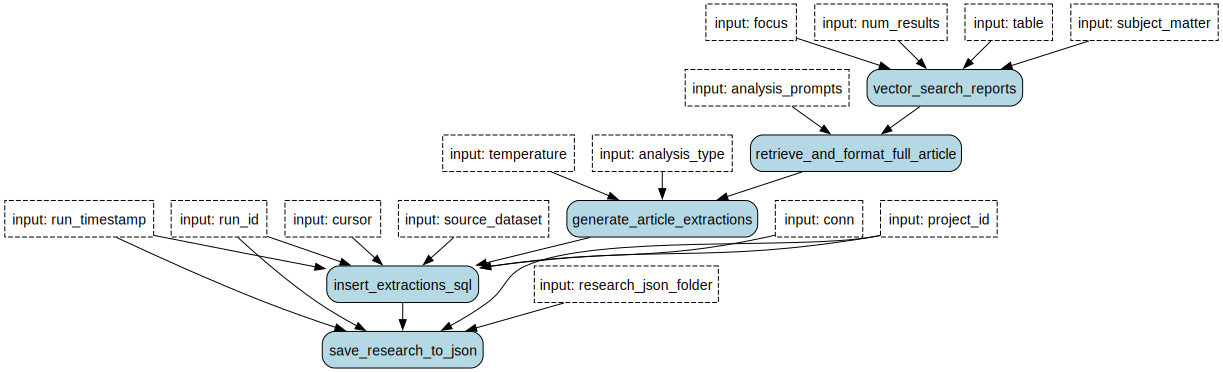

In [162]:
extraction_app.visualize("./graph", format="png")

In [163]:
run_timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
run_id = str(uuid4())
project_id = str(uuid4())
project_id = 'rural broadband'
source_dataset = 'CRSReports'

extraction_action, extraction_result, extraction_state = extraction_app.run(
    halt_after=["save_research_to_json"],
    inputs={
        "subject_matter": subject_matter,
        "focus": focus,
        "analysis_type": analysis_type,
        "analysis_prompts": analysis_prompts,
        "table": table,
        "temperature":0.2,
        "run_id": run_id,
        "project_id": project_id,
        "run_timestamp": run_timestamp,
        "conn": conn,
        "cursor": cursor,
        "research_json_folder": research_json_folder,
        "num_results": 3,
        "source_dataset": source_dataset
    }
)

['RL33816' 'R47017']


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

RL33816
RL33816__5___1
RL33816__6___1
RL33816__7___1
RL33816__8___1
RL33816__10___1
RL33816__16___1
RL33816__17___1
RL33816__18___1
RL33816__21___1
RL33816__24___1
10
R47017
R47017__1___1
R47017__2___1
R47017__3___1
R47017__4___1
R47017__5___1
R47017__7___1
R47017__8___1
R47017__9___1
R47017__11___1
R47017__16___1
R47017__17___1
R47017__18___1
R47017__22___1
R47017__23___1
14


In [136]:
run_id

'49f26f2c-e4b0-43ba-8f97-c9ffb48c2d37'

In [137]:
research_json_folder

PosixPath('project_research/json_data')

In [28]:
research_table = 'research_runs'
research_table_sql = """CREATE TABLE IF NOT EXISTS research_runs (
    run_id TEXT,
    project_id TEXT,
    run_timestamp TEXT,
    subject_matter TEXT,
    focus TEXT,
    analysis_type TEXT,
    id TEXT,
    type TEXT,
    typeId TEXT,
    number TEXT,
    active INTEGER, -- 0 for false, 1 for true
    topics TEXT,    -- Store as JSON string or comma-separated values
    date TEXT,      -- Store as ISO8601 string (e.g., "YYYY-MM-DD")
    title TEXT,
    summary TEXT,
    doc_id TEXT,
    filename TEXT,
    source_file TEXT,
    source_document TEXT,
    source_dataset TEXT
);"""

overview_table = 'overviews'
overview_table_sql = """CREATE TABLE IF NOT EXISTS overviews (
    run_id TEXT,
    run_timestamp TEXT,
    project_id TEXT,
    subject_matter TEXT,
    focus TEXT,
    analysis_type TEXT,
    overview TEXT,
    overview_citations TEXT,
    overview_type TEXT,
    overview_pages TEXT,
    source_document TEXT,
    source_dataset TEXT
);"""

overview_sources_table = 'overview_sources'
overview_sources_table_sql = """CREATE TABLE IF NOT EXISTS overview_sources (
    run_id TEXT,
    run_timestamp TEXT,
    project_id TEXT,
    subject_matter TEXT,
    focus TEXT,
    analysis_type TEXT,
    text TEXT,
    citation TEXT,
    source_document TEXT,
    source_dataset TEXT
);"""

# drop_research_sql = "DROP TABLE IF EXISTS research_runs;"
# drop_overviews_sql = "DROP TABLE IF EXISTS overviews;"
# drop_overview_sources_sql = "DROP TABLE IF EXISTS overview_sources;"
#
#
# cursor.execute(drop_research_sql)
# cursor.execute(drop_overviews_sql)
# cursor.execute(drop_overview_sources_sql)
# conn.commit()
#
# cursor.execute(research_table_sql)
# cursor.execute(overview_table_sql)
# cursor.execute(overview_sources_table_sql)
# conn.commit()

# conn.close()

In [95]:
def insert_extraction_data(extractions, cursor, conn, run_id, project_id, run_timestamp, subject_matter, focus, analysis_type, source_dataset):
    project_run_columns = [
        'run_id', 'run_timestamp', 'project_id', 'subject_matter', 'focus', 'analysis_type',
        'id', 'type', 'typeId', 'number', 'active', 'topics', 'date',
        'title', 'summary', 'doc_id', 'filename', 'source_file', 'source_document','source_dataset'
    ]

    overview_columns = [
            'run_id', 'run_timestamp', 'project_id', 'subject_matter', 'focus', 'analysis_type', 'overview', 'overview_citations', 'overview_type', 'overview_pages', 'source_document','source_dataset'
        ]

    overview_sources_columns = ['run_id', 'run_timestamp', 'project_id', 'subject_matter', 'focus', 'analysis_type','text','citation','source_document','source_dataset']

    for document_id, _extraction in extractions.items():
        research_run_insert_sql = insert_research_metadata(_extraction, run_id, project_id, run_timestamp, subject_matter, focus, analysis_type, document_id, source_dataset, project_run_columns)
        cursor.execute(research_run_insert_sql[0], research_run_insert_sql[1])

        overview_insert_sql = insert_overview_metadata(_extraction, run_id, project_id, run_timestamp, subject_matter, focus, analysis_type, document_id, source_dataset, overview_columns)
        cursor.execute(overview_insert_sql[0], overview_insert_sql[1])

        for _cite_source in _extraction['overview_cite_sources']:
            overview_sources_insert_sql = insert_research_sources_metadata(_cite_source, run_id, project_id, run_timestamp, subject_matter, focus, analysis_type, document_id, source_dataset, overview_sources_columns)
            cursor.execute(overview_sources_insert_sql[0], overview_sources_insert_sql[1])

    conn.commit()